In [14]:
MODELS_FROM_FILE = 1
IMPORTANCES_FROM_FILE = 1

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score, precision_score, balanced_accuracy_score, f1_score, roc_auc_score, fbeta_score, make_scorer, roc_curve, precision_recall_curve, accuracy_score
from sklearn.metrics import PrecisionRecallDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

    
pd.set_option("display.max_columns", None)
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', 100)


data_intermediate_dir = "data/intermediate/"
item_lvl_w_imp = pd.read_csv(data_intermediate_dir + "item_lvl_w_impairment.csv")


# Prepare input and ouptut column names

diag_cols = [x for x in item_lvl_w_imp.columns if x.startswith("Diag: ")] # All diagnosis columns

input_cols = [x for x in item_lvl_w_imp.columns if 
                       not x.startswith("Diag: ") 
                       and not x.startswith("WIAT")
                       and not x.startswith("WISC")] # Input columns are all columns except Diagnosis, WIAT, and WISC columns

learning_disorder_cols = [
    "Diag: Specific Learning Disorder with Impairment in Reading",
    "Diag: Specific Learning Disorder with Impairment in Mathematics",
    "Diag: Intellectual Disability-Mild",
    "Diag: Borderline Intellectual Functioning",
    "Diag: Specific Learning Disorder with Impairment in Written Expression"
]

# Separate test set for all diagnoses

# Shuffle the dataset 
shuffle_df = item_lvl_w_imp.sample(frac=1, random_state=42)

# Define a size for the train set 
train_size = int(0.7 * len(item_lvl_w_imp))

# Split the dataset 
train_set = shuffle_df[:train_size]
test_set = shuffle_df[train_size:] # Don't touch this until the end

# Train_train and Validation set
# Define a size for your train_train set 
train_train_size = int(0.7 * len(train_set))

# Split your dataset 
train_train_set = train_set[:train_train_size]
val_set = train_set[train_train_size:]

((3,), (3,), (1,), (4,), (5,), (), (1,))


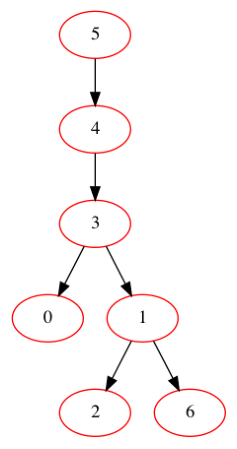

((3,), (3, 7), (1,), (4,), (5,), (), (1,), (0, 4))


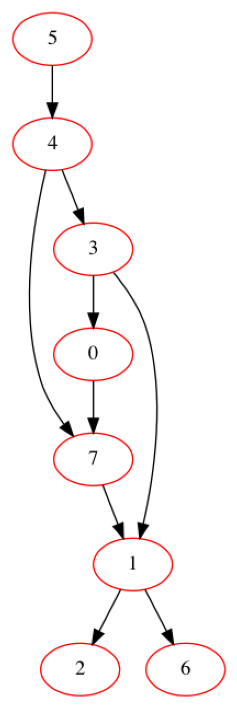

In [30]:
# Try building bayesian network on optimal features for Combined ADHD

from pomegranate import BayesianNetwork
import seaborn, time
seaborn.set_style('whitegrid')

columns = [
 'SympChck,CSC_36C', # Difficulty remaining seated - 0
 'SympChck,CSC_39P', # Argues and talks back to adults (past) - 1
 'SCQ,SCQ_09', # Appropriate facial expressions - 2
 'SDQ,SDQ_02', # Restless, overactive - 3
 'SWAN,SWAN_16', # Reflects on questions - 4
 'SWAN,SWAN_18', # Enters conversation without interrupting - 5
 'APQ_P,APQ_P_05' # You reward your child for behaving well - 6
]

diag = ['Diag: ADHD-Combined Type']


model = BayesianNetwork.from_samples(train_train_set[columns], algorithm='exact')
print(model.structure)
plt.figure(figsize=(4,16))
model.plot()
plt.show()

model = BayesianNetwork.from_samples(train_train_set[columns+diag], algorithm='exact')
print(model.structure)
plt.figure(figsize=(4,16))
model.plot()
plt.show()

In [21]:
# Check if there are highly correlated features

corr_mat = item_lvl_w_imp[input_cols].corr().abs()
corr_mat_flat = pd.melt(corr_mat.reset_index(), id_vars=['index'], value_vars=[x for x in corr_mat.columns if x!= "index"])

# Check if there corr=1 for some columns that are not the column itself
print("Column combinations with corr=1 that are not the column itself:", len(corr_mat_flat[(corr_mat_flat["value"] == 1) & (corr_mat_flat["index"] != corr_mat_flat["variable"])]))
# => no

# Drop self correlated lines
corr_mat_flat["index-variable"] = corr_mat_flat[['index', 'variable']].values.tolist()
corr_mat_flat["index-variable"] = corr_mat_flat["index-variable"].apply(set)
corr_mat_flat = corr_mat_flat[corr_mat_flat["index-variable"].str.len() != 1]

# Remove repeated rows
corr_mat_flat["index-variable"] = corr_mat_flat["index-variable"].apply(str)
corr_mat_flat = corr_mat_flat.drop_duplicates(subset=["index-variable"])
corr_mat_flat

# Drop columns with correlation over threshold
corr_threshold = 0.3
corr_mat_flat_over_threshold = corr_mat_flat[abs(corr_mat_flat["value"]) > corr_threshold].sort_values(by="index", ascending=False)
print("Column combinations with highest correlation, first 100: ")
display(corr_mat_flat_over_threshold[["index-variable", "value"]].sort_values("value", ascending=False).head(100))
corr_cols = corr_mat_flat_over_threshold["index"].unique()

non_corr_input_cols = list(set(input_cols) - set(corr_cols))
print("Original number of columns: ", len(input_cols), "; number of non-correlated columns: ", len(non_corr_input_cols))

Column combinations with corr=1 that are not the column itself: 0
Column combinations with highest correlation, first 100: 


,index-variable,value
714857,"{'APQ_SR,APQ_SR_07A_WAS_MISSING', 'APQ_SR,APQ_SR_09A_WAS_MISSING'}",0.986598
714010,"{'APQ_SR,APQ_SR_09A_WAS_MISSING', 'APQ_SR,APQ_SR_07A_WAS_MISSING'}",0.986598
714011,"{'APQ_SR,APQ_SR_11A_WAS_MISSING', 'APQ_SR,APQ_SR_07A_WAS_MISSING'}",0.982048
709766,"{'SDQ,SDQ_29_c_WAS_MISSING', 'SDQ,SDQ_30_WAS_MISSING'}",0.977657
714859,"{'APQ_SR,APQ_SR_11A_WAS_MISSING', 'APQ_SR,APQ_SR_09A_WAS_MISSING'}",0.977657
708070,"{'SDQ,SDQ_30_WAS_MISSING', 'SDQ,SDQ_29_a_WAS_MISSING'}",0.977416
708067,"{'SDQ,SDQ_29_b_WAS_MISSING', 'SDQ,SDQ_29_a_WAS_MISSING'}",0.974534
708068,"{'SDQ,SDQ_29_c_WAS_MISSING', 'SDQ,SDQ_29_a_WAS_MISSING'}",0.974534
708918,"{'SDQ,SDQ_29_b_WAS_MISSING', 'SDQ,SDQ_30_WAS_MISSING'}",0.971201
714014,"{'APQ_SR,APQ_SR_20A_WAS_MISSING', 'APQ_SR,APQ_SR_07A_WAS_MISSING'}",0.969422


Original number of columns:  848 ; number of non-correlated columns:  115
